In [1]:
import wavefront_api_client as wave_api
import time
import datetime as dt
import re
import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from mlalgms.statsmodel import detectAnomalies
from utils.converterutils import addHeader
from dateutil.parser import parse


In [21]:
#DO NOT CHANGE
base_url = 'https://intuit.wavefront.com'

api_key = '06258b32-5ada-4485-8e78-886faf7a938b'


#will return % utilization of cpu all sources matching tags
#cpu_query = '100 - rate(ts("collectd.aggregation-cpu-average.cpu-idle", bu=sbg and env=prd and app=qbo and pool=app and location=qcy and source=pprdqboas83b.ie.intuit.net or source=pprdqboas83y.ie.intuit.net))'

#memory metric to scrape
#will return memory utilization for all sources matching tags
#memory_query = 'ts("collectd.memory.memory-used", bu=sbg and app=qbo and env=prd and pool=app and location=qcy and source=pprdqboas83b.ie.intuit.net or source=pprdqboas83y.ie.intuit.net)'

app="ice"
err_5xx_query = 'sum(ts(telegraf.http.server.requests.count, env="prd" and app="[APP]" and status="5*"))'
err_4xx_query = 'sum(ts(telegraf.http.server.requests.count, env="prd" and app="[APP]" and status="4*"))'
avg_latency_query = 'avg(ts(telegraf.http.server.requests.mean, env="prd" and status="2*" and app="[APP]"), app)'

avg_error_query ='avg(align(60s, mean, ts("appdynamics.apm.errors.errors_per_min", env="prd" and app="[APP]")), app)'


#change to give the desired destination for resulting csv file
err_5xx = './err_5xx_data.csv'
err_4xx = './err_4xx_data.csv'
avg_latency = './avg_latency_data.csv'

avg_error = './avg_error_data.csv'


#time in hours to capture in query window
#  easiest to multiply it out for longer periods
#    eg. 1 week = 7 (days/week) * 24 (hours/day)
query_window = 24*7*2

#calculate start and end times in ms
end_time = time.time() * 1000
#end_time = (24*8 * 60 * 60) * 1000
start_time = (end_time) - (query_window * 60 * 60) * 1000
end_time = start_time +(24*5 * 60 * 60) * 1000

#desired query granularity (s, m, h, or d)
query_granularity = 'm'

def retrieveQueryUrl(app, url):
    return url.replace('[APP]', app)




In [16]:
#issue the query through the wavefront query api
def executeQuery( query, client, start_time, end_time):
    query_api = wave_api.QueryApi(client)
    app_query = retrieveQueryUrl(app, query)
    result = query_api.query_api(app_query, str(start_time), query_granularity, e=str(end_time))
    return formatData(result)



#enter resulting data into the dataframe with the timestamp as the index
def formatData(result):
    if result.timeseries is not None:
        for entry in result.timeseries:
            #server_name = entry.host
            #label = entry.label            
            data = np.array(entry.data)
            
            #location = entry.tags[u'location']
            #app = entry.tags[u'app']
            #bu = entry.tags[u'bu']
            
            idx = pd.Series(data[:,0])
            
            dtime = [dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S') for x in idx ]
            dtime1 = [parse(d) for d in dtime]
            y = data[:,1]
            #df = addHeader (idx, y)
            df = addHeader(dtime1,y)
            #print(df.index)
            return df
            #df[app] =  pd.Series(data[:,1], index=data[:,0])
            #return df


In [17]:
# Drawing libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from IPython.core.pylabtools import figsize

In [18]:
def showGraph(name,df):
    ll = df.index.tolist()
    plt_ds = [date2num(dd)  for dd in ll]
    plt.figure(figsize=(15, 7))
    plt.plot_date(plt_ds, df.y)
    plt.title(name+' timeseries')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Metric Value')
    plt.show()


In [19]:

#set up python Wavefront client
config = wave_api.Configuration()
config.host = base_url
client = wave_api.ApiClient(configuration=config, header_name='Authorization', header_value='Bearer ' + api_key)



    

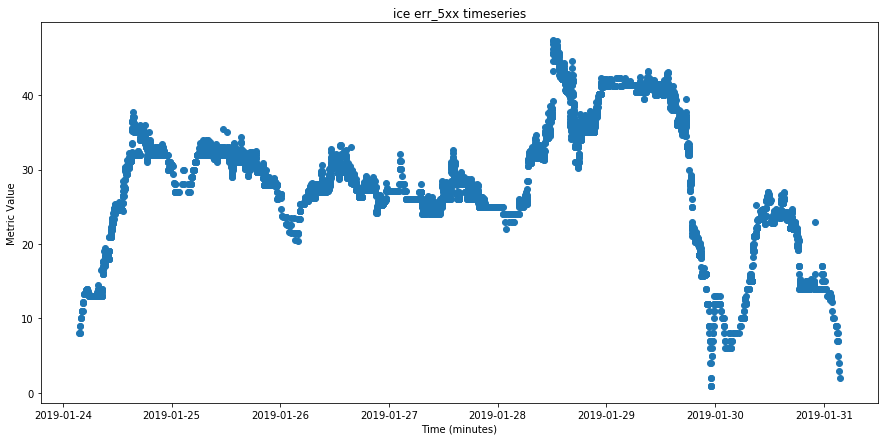

In [61]:

err_5xx_df = executeQuery( err_5xx_query, client,start_time, end_time)
showGraph(app+' err_5xx', err_5xx_df)
#err_5xx_df.plot(legend=False)
err_5xx_df.to_csv(err_5xx)




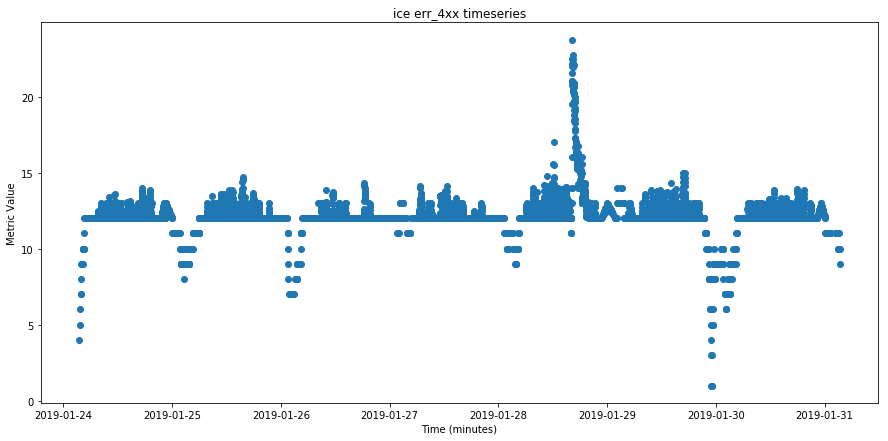

In [62]:
err_4xx_df = executeQuery(err_4xx_query, client,start_time, end_time)
showGraph(app+' err_4xx', err_4xx_df)
err_4xx_df.to_csv(err_4xx)




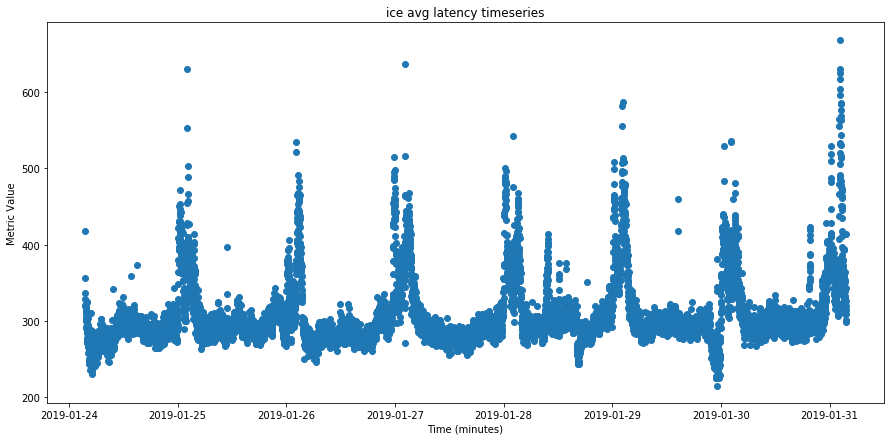

In [63]:
avg_latency_df = executeQuery( avg_latency_query, client,start_time, end_time)
showGraph(app+' avg latency', avg_latency_df)
avg_latency_df.to_csv(avg_latency)



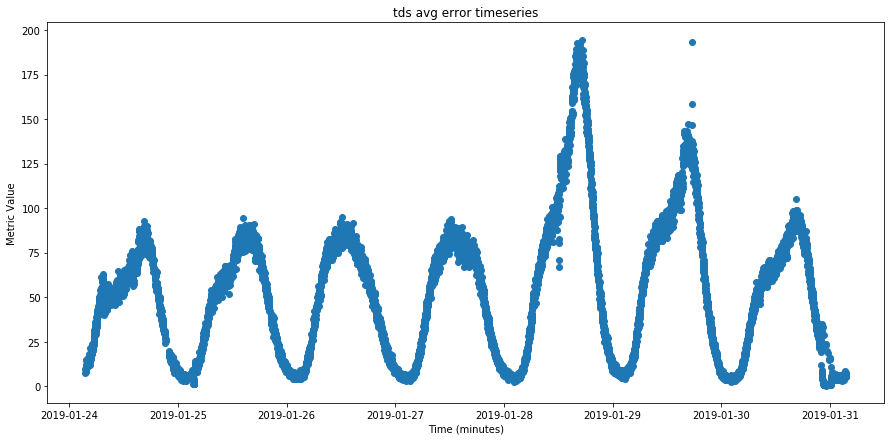

In [22]:
avg_error_df = executeQuery( avg_error_query, client,start_time, end_time)
showGraph('tds avg error', avg_error_df)
avg_error_df.to_csv(avg_error)

In [23]:
from mlalgms.fbprophet  import predictNoneSeasonalityProphetLast
import warnings
warnings.filterwarnings("ignore")

In [24]:
def totimestamp(np_dt):
   return (np_dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


In [25]:
from mlalgms.evaluator import ts_train_test_split
from datetime import datetime


In [47]:
train, test = ts_train_test_split(avg_error_df, split_ratio=0.6)


In [48]:

idx = train.index.get_values()
p_ts = [totimestamp(d) for d in idx]
print(type(p_ts[0]))
p_utc = [datetime.utcfromtimestamp(int(d)) for d in p_ts]
print(type(p_utc[0]))

df_prophet = addHeader (p_ts, train.y.values, p_utc,False)

<class 'numpy.float64'>
<class 'datetime.datetime'>


In [49]:
import pandas as pd
from fbprophet import Prophet
import logging
import numpy as np

PROPHET_PERIOD = 'period'
PROPHET_FREQ = 'freq'
DEFAULT_PROPHET_PERIOD =1
DEFAULT_PROPHET_FREQ  ='T'
  




In [50]:
def predictProphet(timeseries, period=1 ,frequence ='T', seasonality_name='', prior_scale=0.1, columnPosition=0):
    prophet = Prophet()
    if seasonality_name=='daily':
        prophet.add_seasonality('daily', 1, fourier_order=1, prior_scale=prior_scale)
    elif seasonality_name=='weekly':
        prophet.add_seasonality('weekly', 7, fourier_order=3, prior_scale=prior_scale)
    elif seasonality_name=='monthly':
        prophet = Prophet(weekly_seasonality=False)
        prophet.add_seasonality('monthly', 30.5, fourier_order=5,prior_scale=prior_scale)
    elif seasonality_name=='yearly':
        prophet.add_seasonality('yearly', 365, fourier_order=10,prior_scale=prior_scale)    
    prophet.fit(timeseries)
    future = prophet.make_future_dataframe(periods=period,freq=frequence)
    forecast = prophet.predict(future)
    if columnPosition == 0 :
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    else :
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][columnPosition:]
    
def prophetPredictUpperLower(timeseries, period=1,frequence ='T', zscore = 2,seasonality_name='',prior_scale=0.1, columnPosition=0):
    df = timeseries.copy()
    df.dropna()
    orig_len = len(timeseries)
    fc = predictProphet(df, period, frequence,seasonality_name, prior_scale,columnPosition)
    after_len = len(fc)
    print(orig_len ,'  ', after_len)
    if seasonality_name=='':  
        mean = fc[orig_len:].yhat_lower.mean()
        std = fc[orig_len:].yhat_lower.std()
        return mean-zscore*std, mean+zscore*std
    return fc[['ds','yhat_lower','yhat_upper']][orig_len:]
    #return forecast.yhat_lower[size-1], forecast.yhat_upper[size-1]

In [57]:
dd = prophetPredictUpperLower(df_prophet,1440, 'T',2,'daily') 


5602    7042


In [58]:

idx = test.index.get_values()
p_ts = [totimestamp(d) for d in idx]
p_utc = [datetime.utcfromtimestamp(int(d)) for d in p_ts]


df_prophet_test = addHeader (p_ts, test.y.values, p_utc,False)

test_predict= pd.merge(dd, df_prophet_test, on='ds')



In [59]:
#test_predict.plot(style = ".", figsize = (14,8), title = "Anomaly Detection Using Prophet: CPU Utilization Forecasting")

In [60]:
IS_UPPER_BOUND =1
def detectLowerUpperAnomalies(df , bound=IS_UPPER_BOUND, returnAnomaliesOnly= True):

    ts=[]
    adata=[]
    anomalies=[]
    myshape = df.shape
    nrow = myshape[0]
    for i in range(nrow):  
         isAnomaly = False
         if (not returnAnomaliesOnly):
            ts.append(df['ds'][i])
            adata.append(df['y'][i])
         if bound==IS_UPPER_BOUND:
            if df['y'][i] > df['yhat_upper'][i]:
                if returnAnomaliesOnly:
                    ts.append(df['ds'][i])
                    adata.append(df['y'][i])
                isAnomaly = True
         elif bound==IS_LOWER_BOUND:
            if df['y'][i] < df['yhat_lower'][i]:
                if returnAnomaliesOnly:
                    ts.append(df['ds'][i])
                    adata.append(df['y'][i])
                isAnomaly = True            
         else:   
            if df['y'][i] > df['yhat_upper'][i] or df['y'][i] < df['yhat_lower'][i]:
                if returnAnomaliesOnly:
                    ts.append(df['ds'][i])
                    adata.append(df['y'][i])
                isAnomaly = True
                    
         if returnAnomaliesOnly:
            if isAnomaly:
                anomalies.append(True)
         else:
            anomalies.append(isAnomaly)             
    #return  mae, deviation,addHeader(ts,adata)
    return  ts,adata, anomalies


In [55]:
ts_test, adata_test, anomalies = detectLowerUpperAnomalies(test_predict )

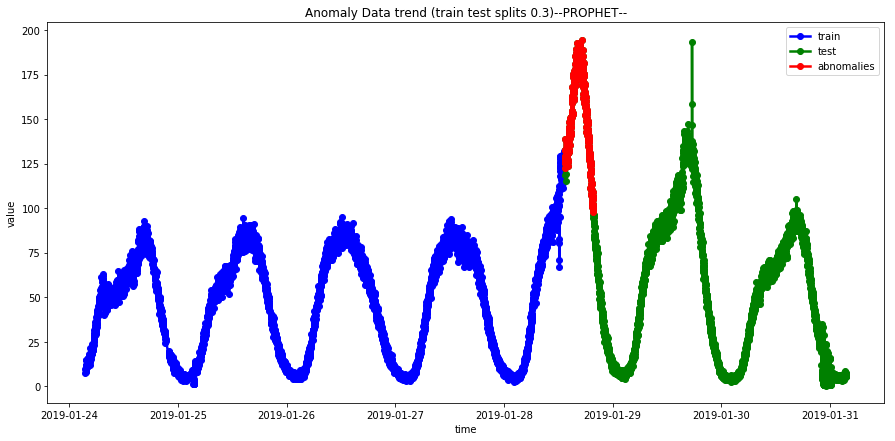

In [56]:
plat_test = [date2num(d)  for d in ts_test]
plat_train = [date2num(d)  for d in train.index.get_values()]
plat_test_origin = [date2num(d)  for d in test.index.get_values()]
plt.figure(figsize=(15, 7))

plt.plot_date(plat_train, train.y,color="blue", linewidth=2.5, linestyle="-", label='train')
plt.plot_date(plat_test_origin, test.y,color="green", linewidth=2.5, linestyle="-", label='test')

plt.plot_date(plat_test, adata_test,color="red", linewidth=2.5, linestyle="-", label='abnomalies')

plt.title('Anomaly Data trend (train test splits 0.3)--PROPHET--')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()